# model-vs-model decision-margin-consistency demo

# dataset: use the [Imagenette](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html) subset for demonstration

The analyses reported in the paper used the full imagenet validation set.

In [2]:
import torch
import warnings
from torchvision import datasets
from torchvision.datasets.utils import download_and_extract_archive
from torchvision import transforms

default_root = torch.hub.get_dir().replace("/hub", "/data")

class ImagenetteWithImageNetLabels(datasets.Imagenette):
    labelmap = {0: 0, 1: 217, 2: 482, 3: 491, 4: 497, 5: 566, 6: 569, 7: 571, 8: 574, 9: 701}

    def __init__(self, root=default_root, *args, **kwargs):
        super().__init__(root, *args, **kwargs)

        # update labels to use new labels
        self._samples = [(fname, self.labelmap[label]) for fname, label in self._samples]
        self.class_to_idx = {name: self.labelmap[label] for name, label in self.class_to_idx.items()}

    def _download(self):
        if self._check_exists():
            warnings.warn(
                f"\nThe directory {self._size_root} already exists, skipping download. "
                f"If you want to re-download or re-extract the images, delete the directory."
            )
        else:
            download_and_extract_archive(self._url, self.root, md5=self._md5)

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImagenetteWithImageNetLabels(split="val", download=True, transform=transform)
dataset

/tmp/ipykernel_1056685/1001509230.py:21: UserWarning: 
The directory /n/alvarez_lab_tier1/Lab/cache/torch/data/imagenette2 already exists, skipping download. If you want to re-download or re-extract the images, delete the directory.
  warnings.warn(


Dataset ImagenetteWithImageNetLabels
    Number of datapoints: 3925
    Root location: /n/alvarez_lab_tier1/Lab/cache/torch/data
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# load a model

In [4]:
import torch
from torchvision import models
from torchvision.models.alexnet import AlexNet_Weights
from torchvision.models.resnet import ResNet50_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# get validation results for each individual image

In [5]:
from decision_margin_consistency import validation

In [6]:
validation?

Signature:
validation(
    model,
    dataset,
    topk=(1, 5),
    batch_size=250,
    num_workers=23,
    shuffle=False,
    pin_memory=True,
    meta={},
)
Docstring: <no docstring>
File:      /n/holylabs/LABS/alvarez_lab/Users/alvarez/Projects/decision-margin-consistency/decision_margin_consistency/eval.py
Type:      function

In [7]:
meta = dict(subj="alexnet_supervised_v1", condition="imagenette_val")
df1, summary1 = validation(model, dataset, meta=meta)
summary1

100%|██████████| 16/16 [00:04<00:00,  3.56it/s]


,subj,condition,dm_mean,dm_min,dm_max,dm_kurtosis,top1,top5
0,alexnet_supervised_v1,imagenette_val,1.674988,-7.082578,12.967953,0.939767,74.726115,92.56051


In [8]:
df1.head()

,subj,condition,index,filename,target_label,predicted_label,top5_labels,top5_outputs,target_act,max_nontarget_act,decision_margin,loss,is_correct,top5
0,alexnet_supervised_v1,imagenette_val,0,val/n01440764/ILSVRC2012_val_00009111.JPEG,0,0,"[0, 312, 306, 758, 491]","[10.228203773498535, 8.751699447631836, 8.6338...",10.228204,8.751699,1.044046,1.072416,1.0,1.0
1,alexnet_supervised_v1,imagenette_val,1,val/n01440764/ILSVRC2012_val_00009191.JPEG,0,0,"[0, 389, 391, 395, 394]","[17.51349639892578, 14.029376983642578, 13.087...",17.513496,14.029377,2.463645,0.045515,1.0,1.0
2,alexnet_supervised_v1,imagenette_val,2,val/n01440764/ILSVRC2012_val_00017472.JPEG,0,0,"[0, 391, 389, 390, 395]","[25.484800338745117, 15.573009490966797, 15.01...",25.484800,15.573009,7.008694,0.000108,1.0,1.0
3,alexnet_supervised_v1,imagenette_val,3,val/n01440764/ILSVRC2012_val_00017700.JPEG,0,0,"[0, 389, 395, 391, 390]","[35.61869430541992, 24.49639129638672, 21.8660...",35.618694,24.496391,7.864656,0.000016,1.0,1.0
4,alexnet_supervised_v1,imagenette_val,4,val/n01440764/ILSVRC2012_val_00021740.JPEG,0,391,"[391, 0, 363, 61, 39]","[12.228653907775879, 12.154913902282715, 11.26...",12.154914,12.228654,-0.052142,1.118104,0.0,1.0


In [9]:
# try resnet50
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.to(device)
meta = dict(subj="resnet50_supervised_v1", condition="imagenette_val")
df2, summary2 = validation(model, dataset, meta=meta)
summary2

100%|██████████| 16/16 [00:05<00:00,  3.07it/s]


,subj,condition,dm_mean,dm_min,dm_max,dm_kurtosis,top1,top5
0,resnet50_supervised_v1,imagenette_val,3.692008,-6.802341,18.094248,0.426846,88.585987,98.700637


# compare the models using error consistency and decision-margin consistency

In [12]:
%config InlineBackend.figure_format='retina'

In [14]:
import seaborn as sns
from decision_margin_consistency import compute_consistency

In [15]:
df = compute_consistency(df1, df2)
df

,condition,pair_num,sub1,sub2,sub1_pct_correct,sub2_pct_correct,expected_consistency,observed_consistency,error_consistency,decision_margin_consistency
0,imagenette_val,0,alexnet_supervised_v1,resnet50_supervised_v1,0.747261,0.88586,0.690816,0.813503,0.396809,0.621475


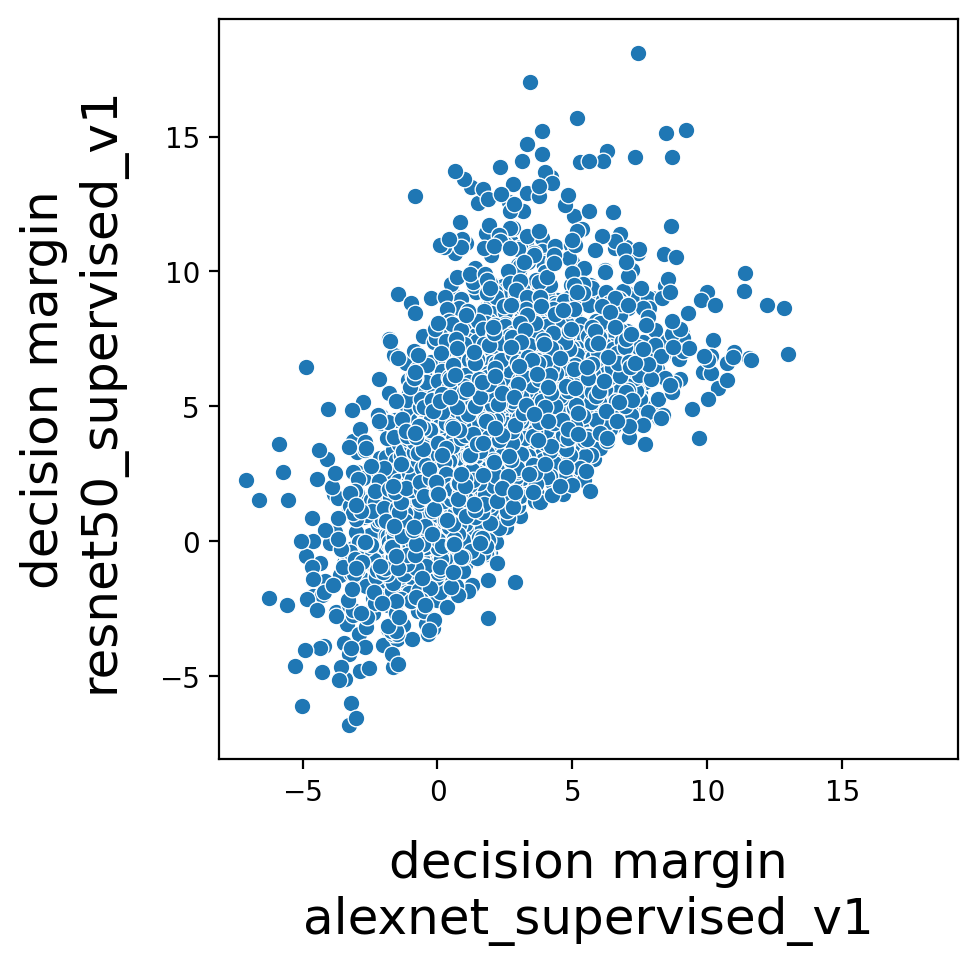

In [25]:
ax = sns.scatterplot(x=df1.decision_margin, y=df2.decision_margin)
ax.axis('square');
ax.set_xlabel(f"decision margin\n{df1.iloc[0].subj}", labelpad=12, fontsize=18);
ax.set_ylabel(f"decision margin\n{df2.iloc[0].subj}", labelpad=12, fontsize=18);

# visualize target vs. max-non-target activation

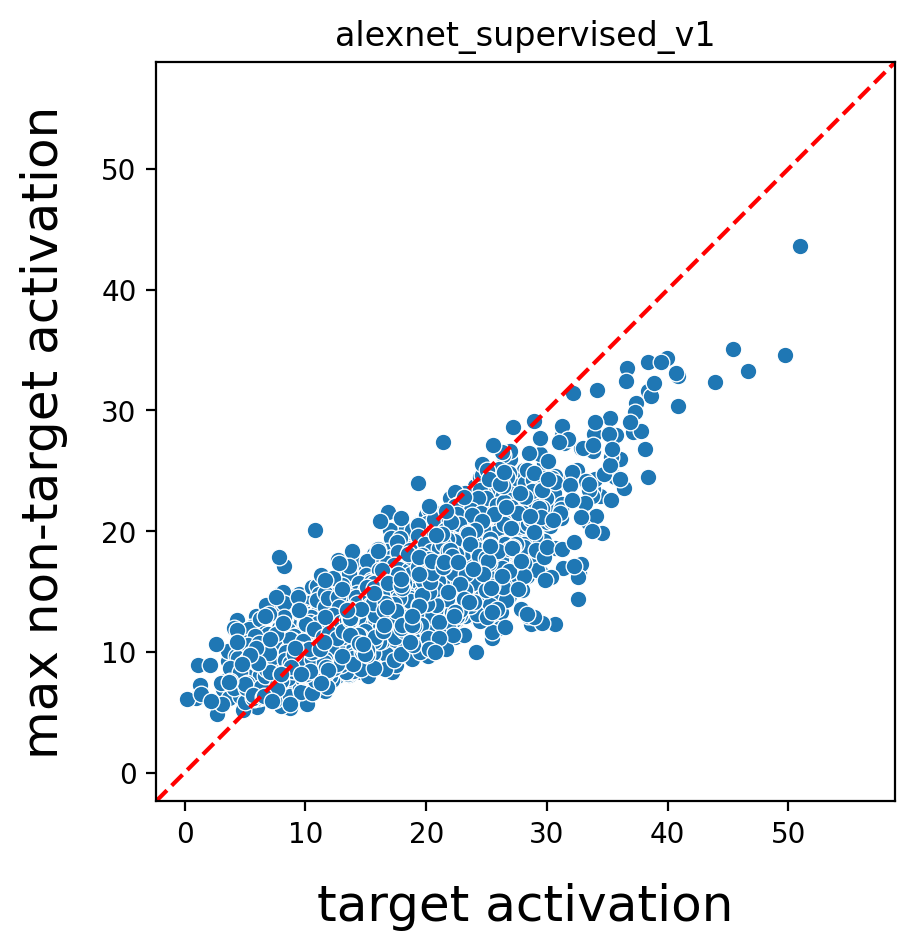

In [30]:
ax = sns.scatterplot(x=df1.target_act, y=df1.max_nontarget_act)
ax.axis('square');
ax.set_xlabel(f"target activation", labelpad=12, fontsize=18);
ax.set_ylabel(f"max non-target activation", labelpad=12, fontsize=18);
ax.set_title(f"{df1.iloc[0].subj}")

# Get the current axis limits
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()
limits = [min(x_limits[0], y_limits[0]), max(x_limits[1], y_limits[1])]

# Plot the unit line (y = x)
ax.plot(limits, limits, 'r--', linewidth=1.5, label='y=x')

# Update the axis limits to match the unit line
ax.set_xlim(limits);
ax.set_ylim(limits);